# 08 — Transformación Proyectiva (Homografía) en 2D

## Teoría (coordenadas homogéneas, matriz 3×3)

La **transformación proyectiva** (o **homografía**) mapea puntos de un plano a otro usando una matriz $( \mathbf{H} \in \mathbb{R}^{3\times 3} )$ definida **a escala** (hasta un factor).
En **coordenadas homogéneas**:
$
\begin{bmatrix}
x_2 \\ y_2 \\ w
\end{bmatrix}$
$=
\mathbf{H}$
$\begin{bmatrix}
x_1 \\ y_1 \\ 1
\end{bmatrix}$,
$\qquad
\mathbf{H}=$
$\begin{bmatrix}
h_{11} & h_{12} & h_{13} \\
h_{21} & h_{22} & h_{23} \\
h_{31} & h_{32} & h_{33}
\end{bmatrix}.
$

Para volver a coordenadas cartesianas:
$
x'_2 = \frac{x_2}{w}, \qquad y'_2 = \frac{y_2}{w}.
$

Una homografía está determinada (salvo escala) por **cuatro pares de puntos no colineales** (4 correspondencias punto a punto).
OpenCV provee:
- `cv2.getPerspectiveTransform(src_pts, dst_pts)` cuando damos **4 puntos** exactos.
- `cv2.findHomography(src_pts, dst_pts, method=RANSAC)` para datos con ruido/outliers.

La aplicación sobre una imagen se hace con:
- `cv2.warpPerspective(img, H, (W, H))`.


## Implementación en OpenCV

1. **Deformación proyectiva** controlada: moveremos las esquinas de la imagen para crear una vista "trapezoidal".  
2. **Rectificación** de un cuadrilátero interno: seleccionar una región y llevarla a un rectángulo (simulando *bird's-eye*).  


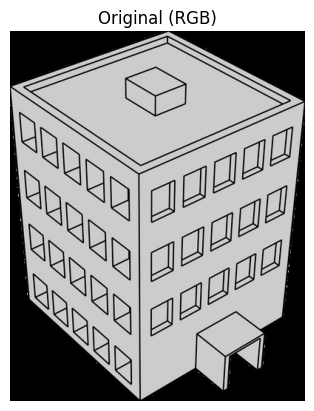

In [2]:
# ✅ Importar librerías y cargar imagen
import cv2
import numpy as np
import matplotlib.pyplot as plt

# MISMA ruta que venimos usando (ajusta si cambió)
img_bgr = cv2.imread(r"C:\Users\20808\Documents\Repositorios\Vision_en_Robotica\imagenes\edificio.png")
if img_bgr is None:
    raise FileNotFoundError("⚠️ No se pudo cargar la imagen. Verifica la ruta.")

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
h, w = img_rgb.shape[:2]

plt.imshow(img_rgb); plt.title("Original (RGB)"); plt.axis("off"); plt.show()


### Ejemplo 1 — Deformación proyectiva de toda la imagen (mover esquinas)

Definimos 4 puntos **origen** (las esquinas) y 4 puntos **destino** (un trapecio). Usamos `getPerspectiveTransform` + `warpPerspective`.


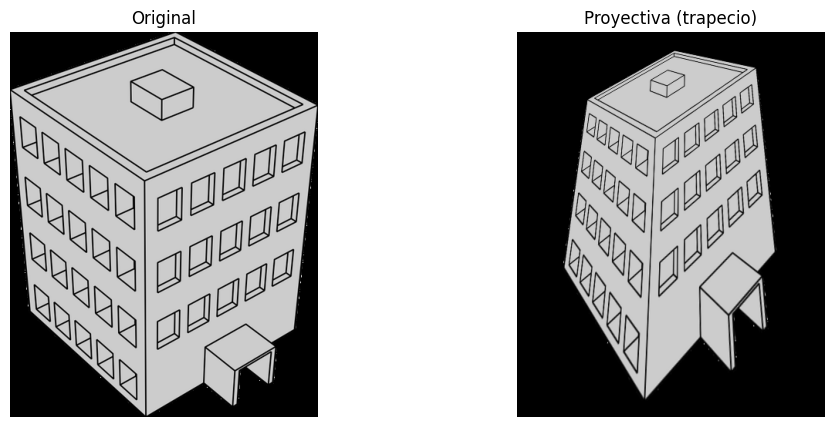

In [3]:
# Puntos fuente: esquinas del lienzo
src = np.float32([[0,0], [w-1,0], [w-1,h-1], [0,h-1]])

# Puntos destino: trapecio (ajusta los offsets para distintos efectos)
offset_x = int(0.25*w)
offset_y = int(0.10*h)
dst = np.float32([
    [0+offset_x,     0+offset_y],
    [w-1-offset_x,   0+0       ],
    [w-1,            h-1-offset_y],
    [0,              h-1       ]
])

H = cv2.getPerspectiveTransform(src, dst)
proj = cv2.warpPerspective(img_rgb, H, (w, h), flags=cv2.INTER_LINEAR,
                           borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.imshow(img_rgb); plt.title("Original"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(proj);    plt.title("Proyectiva (trapecio)"); plt.axis("off")
plt.show()


### Ejemplo 2 — Rectificación de un cuadrilátero interno (*bird's‑eye* de una región)

Seleccionamos un **cuadrilátero** dentro de la imagen (simulando un plano inclinado) y lo mapeamos a un **rectángulo** de salida.
Esto es análogo a **rectificar un plano** (p. ej., el piso o una hoja vista en perspectiva).

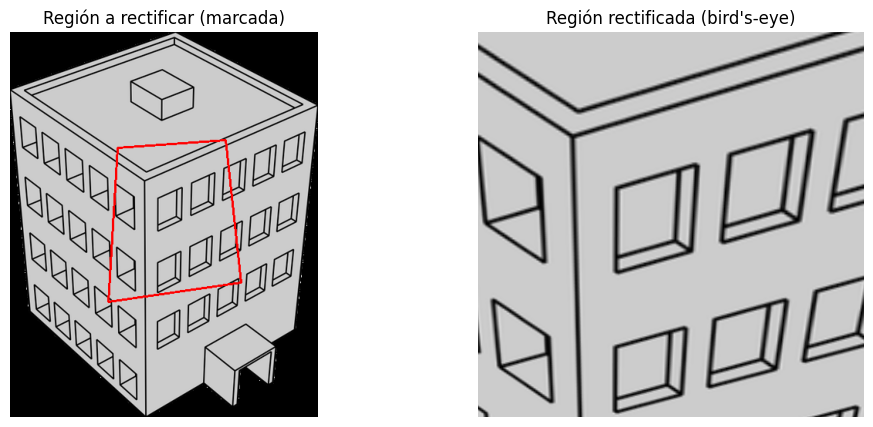

In [4]:
# Definir una región cuadrilátera interna (ajusta estos puntos si quieres otra zona)
quad_src = np.float32([
    [int(0.35*w), int(0.30*h)],
    [int(0.70*w), int(0.28*h)],
    [int(0.75*w), int(0.65*h)],
    [int(0.32*w), int(0.70*h)],
])

# Tamaño deseado del rectángulo de salida
out_W, out_H = 400, 400

quad_dst = np.float32([
    [0, 0],
    [out_W-1, 0],
    [out_W-1, out_H-1],
    [0, out_H-1],
])

H_rect = cv2.getPerspectiveTransform(quad_src, quad_dst)
rectified = cv2.warpPerspective(img_rgb, H_rect, (out_W, out_H), flags=cv2.INTER_LINEAR,
                                borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))

# Visualización
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(img_rgb); ax1.set_title("Región a rectificar (marcada)"); ax1.axis("off")

# dibujar la región sobre la original
poly = quad_src.astype(int)
for i in range(4):
    p1 = tuple(poly[i])
    p2 = tuple(poly[(i+1)%4])
    cv2.line(img_rgb, p1, p2, (255,0,0), 2)  # ojo: img_rgb es RGB; dibujar con rojo puro
ax1.imshow(img_rgb)

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(rectified); ax2.set_title("Región rectificada (bird's-eye)"); ax2.axis("off")

plt.show()


### Guardado (opcional) en la misma carpeta de la imagen original

In [5]:
import os
img_path = r"C:\Users\20808\Documents\Repositorios\Vision_en_Robotica\imagenes\lenna.png"
carpeta = os.path.dirname(img_path)
nombre, ext = os.path.splitext(os.path.basename(img_path))

cv2.imwrite(os.path.join(carpeta, f"{nombre}_projective_trapecio{ext}"), cv2.cvtColor(proj, cv2.COLOR_RGB2BGR))
cv2.imwrite(os.path.join(carpeta, f"{nombre}_rectificada{ext}"), cv2.cvtColor(rectified, cv2.COLOR_RGB2BGR))
print("✅ Archivos guardados en la carpeta de la imagen original.")


✅ Archivos guardados en la carpeta de la imagen original.


## Aplicaciones en robótica

- **Vista cenital (bird's‑eye)** para navegación: rectificar el **piso** o carriles desde una cámara inclinada.  
- **Registro y mosaicos**: alinear imágenes de un mismo plano desde diferentes puntos de vista.  
- **Mediciones métricas**: una vez rectificado un plano, se pueden medir distancias/áreas con escala conocida.  
- **Lectura robusta de marcadores/etiquetas**: deshacer la perspectiva para OCR, códigos, AprilTags/ArUco.  
- **Calibración de cámara–plano de trabajo** en manipuladores: homografía entre imagen y mesa de trabajo.  
